<a href="https://colab.research.google.com/github/yingluliu/bond-data/blob/main/tntorch_bs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/rballester/tntorch.git




  Cloning https://github.com/rballester/tntorch.git to /tmp/pip-req-build-01c0s14k
  Running command git clone --filter=blob:none --quiet https://github.com/rballester/tntorch.git /tmp/pip-req-build-01c0s14k
  Resolved https://github.com/rballester/tntorch.git to commit 6be3903e37d30d13da4600d493dcf0e92016c01e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 883.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━

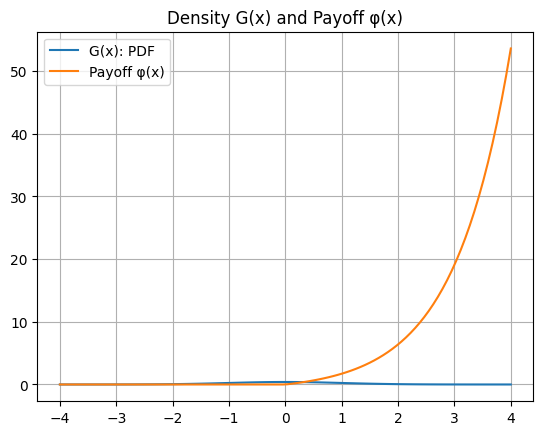

Approximate TT option price = 0.885336


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tntorch import Tensor

# Step 1:
n = 100
x_min, x_max = -4, 4
x = np.linspace(x_min, x_max, n)
dx = x[1] - x[0]

# Step 2:
mu, sigma = 0.0, 1.0
G_values = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
G_tensor = Tensor(G_values.reshape(n, 1), ranks_tt=8)

# Step 3: φ(x) = max(e^x - K, 0)
K = 1.0
payoff_values = np.maximum(np.exp(x) - K, 0)
phi_tensor = Tensor(payoff_values.reshape(n, 1), ranks_tt=8)

# Step 4:
plt.plot(x, G_values, label='G(x): PDF')
plt.plot(x, payoff_values, label='Payoff φ(x)')
plt.title("Density G(x) and Payoff φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: price = ∫ G(x) * φ(x) dx
price_tt = (G_tensor * phi_tensor).sum().item() * dx
print(f"Approximate TT option price = {price_tt:.6f}")



In [ ]:
import numpy as np
from scipy.stats import norm

#
n = 100
x_min, x_max = -4, 4
x = np.linspace(x_min, x_max, n)
dx = x[1] - x[0]

#
K = 1.0
mu = 0.0
sigma = 1.0

# S, G(x), φ(x)
S_vals = np.exp(x)
G_values = norm.pdf(x, loc=mu, scale=sigma)
payoff_values = np.maximum(S_vals - K, 0)

# benchmark price
benchmark_price = np.sum(G_values * payoff_values) * dx
print(f"Benchmark price (based on payoff, matching TT logic) = {benchmark_price:.6f}")


Benchmark price (based on payoff, matching TT logic) = 0.885336


In [18]:
from scipy.stats import norm
import numpy as np

# Black-Scholes closed-form formula for European call option
def bs_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Match your setup in tntorch code
mu = 0.0          # log-mean of S => S0 = exp(mu)
sigma = 1.0       # volatility
r = 0.0           # risk-free rate
T = 1.0           # maturity
K = 1.0           # strike
S0 = np.exp(0.5)   # initial stock price

# Compute Black-Scholes price
bs_price = bs_call_price(S0=S0, K=K, T=T, r=r, sigma=sigma)
print(f"Black-Scholes benchmark price = {bs_price:.6f}")



Black-Scholes benchmark price = 0.887143


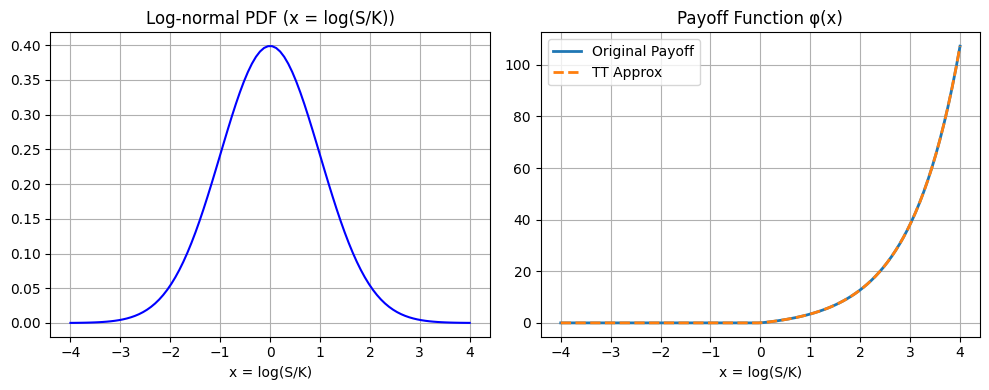

Approximated option price = 1.7706716421742723


In [ ]:
# Step 1: 设置 log-moneyness 范围
x_min, x_max = -4, 4       # -4 到 +4 moneyness，涵盖了99.99%的概率质量
n = 100                    # 网格点数量
x = np.linspace(x_min, x_max, n)
dx = x[1] - x[0]

# Step 2: 反推资产价格 S
K = 2.0                    # 行权价
S = K * np.exp(x)          # 对应的资产价格
G_values = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
payoff_values = np.maximum(K * (np.exp(x) - 1), 0)
phi_tensor = Tensor(payoff_values.reshape(n, 1), ranks_tt=8)
# 📌 STEP 5: 可视化 G(x) 和 φ(x)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, G_values, label="G(x): PDF", color='blue')
plt.title("Log-normal PDF (x = log(S/K))")
plt.xlabel("x = log(S/K)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, payoff_values, label="Original Payoff", linewidth=2)
plt.plot(x, phi_tensor.numpy().flatten(), '--', label="TT Approx", linewidth=2)

plt.title("Payoff Function φ(x)")
plt.xlabel("x = log(S/K)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 📌 STEP 6: 张量收缩，积分近似价格
price_approx = (G_tensor * phi_tensor).sum().item() * dx
print("Approximated option price =", price_approx)

Benchmark price (moneyness-based, payoff-integrated) = 1.770672


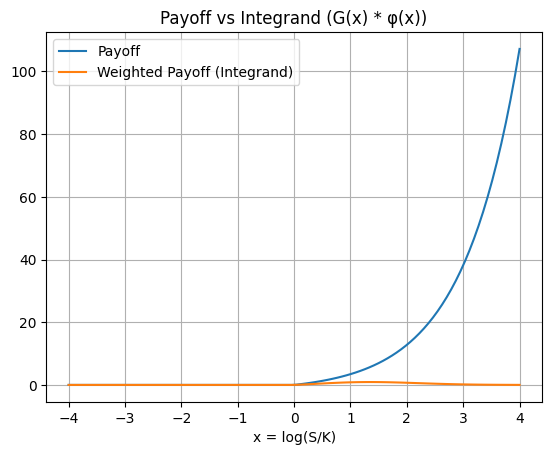

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Step 1: 设置 log-moneyness 范围
x_min, x_max = -4, 4
n = 100
x = np.linspace(x_min, x_max, n)
dx = x[1] - x[0]

# Step 2: 参数设置
K = 2.0
mu = 0.0
sigma = 1.0
T = 1.0
r = 0.0

# Step 3: 构造资产价格 S = K * exp(x)
S = K * np.exp(x)

# Step 4: 构造概率密度 G(x)
G_values = norm.pdf(x, loc=mu, scale=sigma)

# Step 5: 构造 payoff 函数（与 TT 方法完全一致）
payoff_values = K * np.maximum(np.exp(x) - 1, 0)

# Step 6: 数值积分近似期权价格（benchmark）
benchmark_price = np.sum(G_values * payoff_values) * dx

# Step 7: 输出结果
print(f"Benchmark price (moneyness-based, payoff-integrated) = {benchmark_price:.6f}")

# Step 8: 可视化（可选）
plt.plot(x, payoff_values, label='Payoff')
plt.plot(x, G_values * payoff_values, label='Weighted Payoff (Integrand)')
plt.title('Payoff vs Integrand (G(x) * φ(x))')
plt.xlabel('x = log(S/K)')
plt.grid(True)
plt.legend()
plt.show()



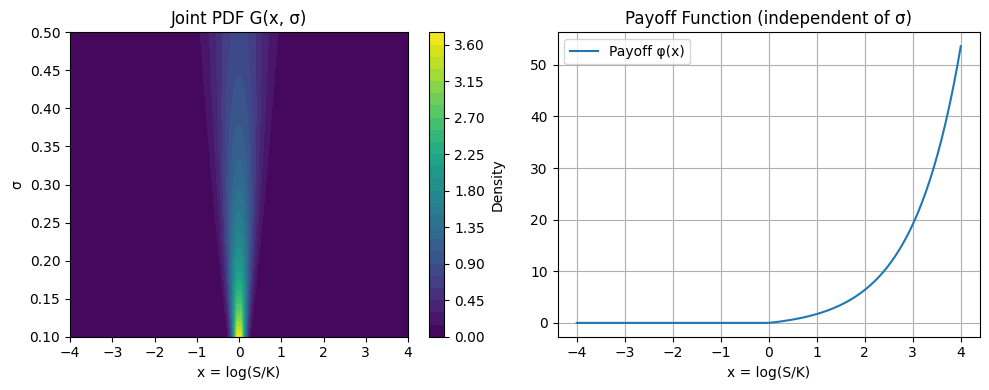

Approximated price (integrated over x and σ): 0.062270664442811915


In [ ]:
#二维张量
import numpy as np
import matplotlib.pyplot as plt
from tntorch import Tensor

# -------------------------------
# Step 1: 构建二维网格 (x, sigma)
# -------------------------------
n = 100                                # log-moneyness 维度数量
m = 50                                 # sigma 维度数量
x = np.linspace(-4, 4, n)
sigma_vals = np.linspace(0.1, 0.5, m)  # 合理的波动率范围
dx = x[1] - x[0]
dsigma = sigma_vals[1] - sigma_vals[0]

X, Sigma = np.meshgrid(x, sigma_vals, indexing='ij')

# -------------------------------
# Step 2: 构建二维分布张量 G(x, sigma)
# -------------------------------
mu = 0.0
G_joint = (1 / (Sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((X - mu) / Sigma)**2)

# 转换为 TT 格式（shape: [n, m] → 2D Tensor）
G_tensor_2d = Tensor(G_joint.reshape(n, m), ranks_tt=8)

# -------------------------------
# Step 3: 构建 φ(x)，广播成 φ(x, σ)
# -------------------------------
K = 1.0
payoff_values = np.maximum(K * (np.exp(x) - 1), 0)   # shape: (n,)
payoff_2d = np.tile(payoff_values.reshape(n, 1), (1, m))  # broadcast 到 shape (n, m)
phi_tensor_2d = Tensor(payoff_2d, ranks_tt=8)

# -------------------------------
# Step 4: 可视化部分切片
# -------------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.contourf(X, Sigma, G_joint, levels=30, cmap='viridis')
plt.title("Joint PDF G(x, σ)")
plt.xlabel("x = log(S/K)")
plt.ylabel("σ")
plt.colorbar(label="Density")

plt.subplot(1, 2, 2)
plt.plot(x, payoff_values, label='Payoff φ(x)')
plt.title("Payoff Function (independent of σ)")
plt.xlabel("x = log(S/K)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# Step 5: 张量收缩积分，估算期权价格
# -------------------------------
price_approx_2d = (G_tensor_2d * phi_tensor_2d).sum().item() * dx * dsigma
print("Approximated price (integrated over x and σ):", price_approx_2d)
